In [1]:
import numpy as np
import sys as sys
import os as os
import yaml as yaml

from geometric_clustering import Geometric_Clustering

from graph_generator import generate_graph


#get the graph from terminal input 
graph_tpe = 'karate'#sys.argv[-1]

#load parameters
params = yaml.load(open('graph_params.yaml','rb'))[graph_tpe]
print('Used parameters:', params)


# =============================================================================
# Set parameters
# =============================================================================

# diffusion time scale 
t_min = params['t_min']
t_max = params['t_max']
n_t = params['n_t']

# set mx(k) = 0 if mx(k) < (1-cutoff)* max_k( mx(k) )
cutoff = params['cutoff']

# regularising parameter - set = 0 for exact 
# (the larger the more accurate, but higher cost, 
# and too large can blow up)                           
lamb = params['lamb']


workers = 16               # numbers of cpus
GPU = 0


#create a folder and move into it
if not os.path.isdir(graph_tpe):
    os.mkdir(graph_tpe)

os.chdir(graph_tpe)

        
# load graph 
G, pos  = generate_graph(tpe = graph_tpe, params = params)
         
# initialise the code with parameters and graph 
gc = Geometric_Clustering(G, pos = pos, t_min = t_min, t_max = t_max, n_t = n_t, log = True, cutoff = cutoff, lamb = lamb)

#first compute the geodesic distances
gc.compute_distance_geodesic()
gc.compute_OR_curvatures()


Used parameters: {'t_min': -5.0, 't_max': 2.0, 'n_t': 100, 'cutoff': 1.0, 'lamb': 0.0}
Compute the measures


/home/arnaudon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app
100%|██████████| 34/34 [00:03<00:00,  9.92it/s]

Compute the edge curvatures



100%|██████████| 78/78 [00:15<00:00,  5.94it/s]


In [18]:
# compute all neighbourhood densities
import scipy as sc
import pylab as plt
import networkx as nx
def mx_comp(L, T, cutoff, i):
    N = np.shape(L)[0]

    def delta(i, n):
        p0 = np.zeros(n)
        p0[i] = 1.
        return p0


    mx_all = [] 
    Nx_all = []

    mx_tmp = delta(i, N) #set initial condition
    T = [0,] + list(T) #add time 0
    for i in range(len((T))-1): 
        #compute exponential by increments (faster than from 0)
        mx_tmp = sc.sparse.linalg.expm_multiply(-(T[i+1]-T[i])*L, mx_tmp)

        Nx = np.argwhere(mx_tmp >= (1-cutoff)*np.max(mx_tmp))
        mx_all.append(sc.sparse.lil_matrix(mx_tmp[Nx]/np.sum(mx_tmp[Nx])))
        Nx_all.append(Nx)

    return mx_all, Nx_all


def plot_measure_graph(self, t,mx1, mx2,  node_size  = 100, edge_width = 1):

        """
        plot the curvature on the graph for a given time t
        """

        plt.figure(figsize = self.figsize)

        edge_vmin = -np.max(abs(self.Kappa[:,t]))
        edge_vmax = np.max(abs(self.Kappa[:,t]))
        
        self.node_curvature()

        vmin = 0# -np.max(abs(mx))
        vmax = 1#np.max(abs(mx))
        mx1 /= np.max(mx1)
        mx2 /= np.max(mx2)

        node_size1 = mx1*node_size
        node_size2 = mx2*node_size

        from matplotlib.markers import MarkerStyle
        ms1 = MarkerStyle('o', fillstyle = 'left')
        ms2 = MarkerStyle('o', fillstyle = 'right')
        node_color1 = 'C4'
        node_color2 = 'C2'

        nodes = nx.draw_networkx_nodes(self.G, pos = self.pos, node_size = node_size1, node_color = node_color1, vmin = vmin, vmax = vmax,  cmap=plt.get_cmap('viridis'),node_shape=ms1)

        edges = nx.draw_networkx_edges(self.G, pos = self.pos, width = edge_width, edge_color = 'k', edge_vmin = edge_vmin, edge_vmax = edge_vmax, edge_cmap=plt.get_cmap('coolwarm'))

        plt.colorbar(edges, label='Curvature')

        if self.node_labels:
            old_labels={}
            for i in self.G:
                old_labels[i] = str(i) + ' ' + self.G.node[i]['old_label']
            nx.draw_networkx_labels(self.G, pos = self.pos, labels = old_labels)
        nodes = nx.draw_networkx_nodes(self.G, pos = self.pos, node_size = node_size2, node_color = node_color2, vmin = vmin, vmax = vmax,  cmap=plt.get_cmap('viridis'),node_shape=ms2)


        limits = plt.axis('off') #turn axis odd
%matplotlib notebook

In [3]:
i = 2
j = 13
mx_1, Nx_1 = mx_comp(gc.L,gc.T,gc.cutoff, i)
mx_2, Nx_2 = mx_comp(gc.L,gc.T,gc.cutoff, j)

<IPython.core.display.Javascript object>


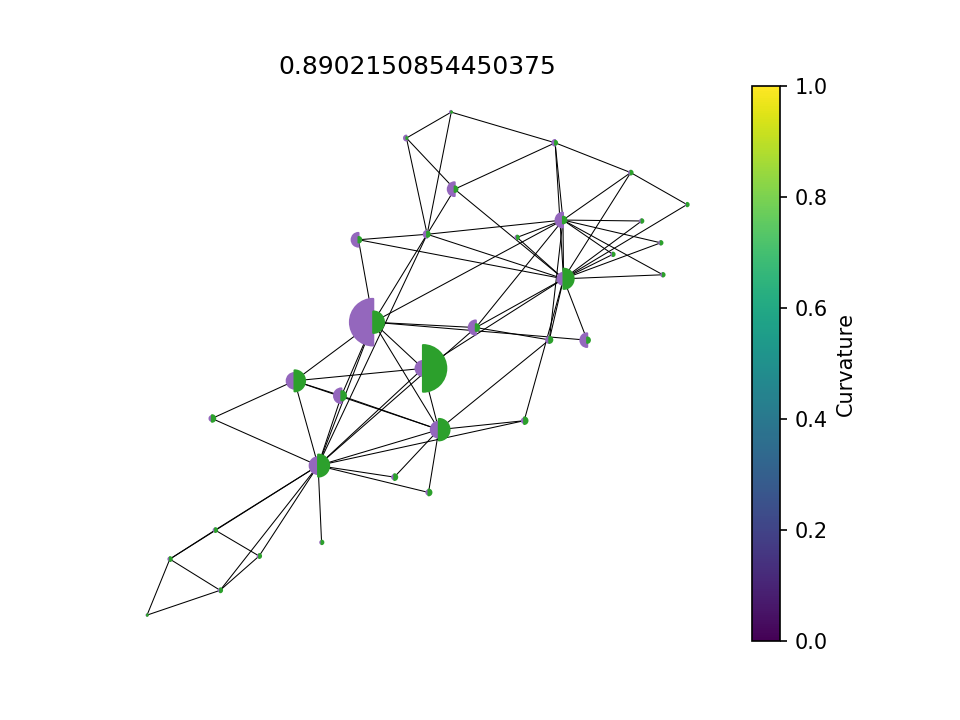

In [20]:
t = 70
mx1 = mx_1[t].toarray().flatten()
mx2 = mx_2[t].toarray().flatten()

gc.node_labels = False
plot_measure_graph(gc, t, mx1, mx2,  node_size  = 500, edge_width = 0.5)
plt.title(gc.T[t])
plt.savefig('mxs.svg', bbox_inches='tight')

<IPython.core.display.Javascript object>


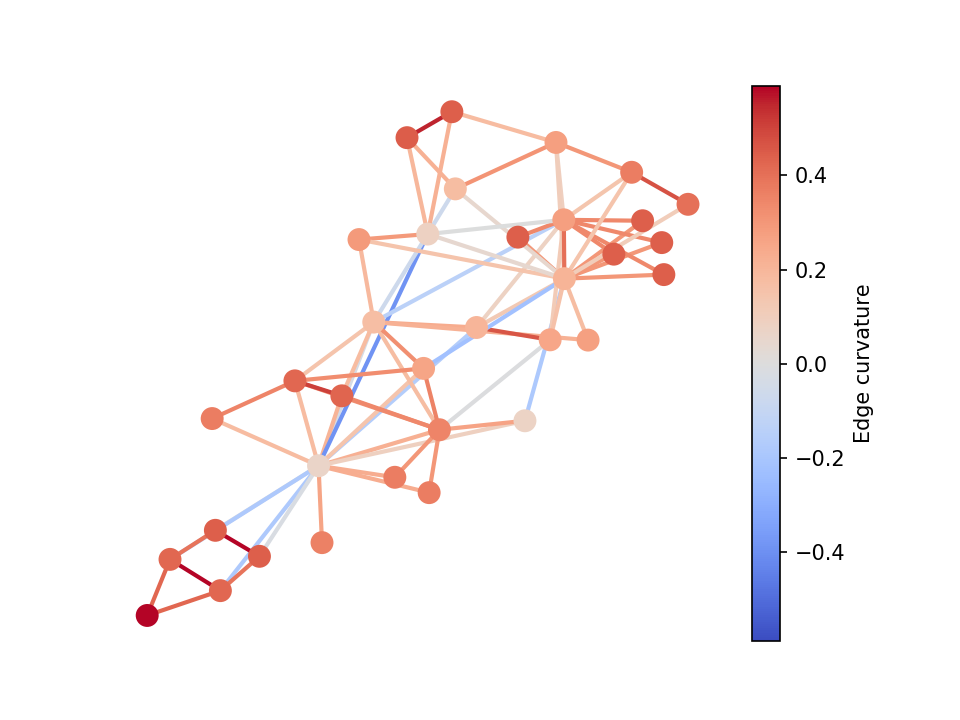

In [23]:
gc.plot_curvature_graph(t)
plt.savefig('curvature.svg', bbox_inches='tight')

In [5]:
# compute all neighbourhood densities
def mx_comp(L, T, cutoff, i):
    N = np.shape(L)[0]

    def delta(i, n):
        p0 = np.zeros(n)
        p0[i] = 1.
        return p0


    mx_all = [] 
    Nx_all = []

    mx_tmp = delta(i, N) #set initial condition
    T = [0,] + list(T) #add time 0
    for i in range(len((T))-1): 
        #compute exponential by increments (faster than from 0)
        mx_tmp = sc.sparse.linalg.expm_multiply(-(T[i+1]-T[i])*L, mx_tmp)

        Nx = np.argwhere(mx_tmp >= (1-cutoff)*np.max(mx_tmp))
        mx_all.append(sc.sparse.lil_matrix(mx_tmp[Nx]/np.sum(mx_tmp[Nx])))
        Nx_all.append(Nx)

    return mx_all, Nx_all
import ot

# compute curvature for an edge ij
def zeta_comp(mx_all, dist, it, e):
    i = e[0]
    j = e[1]

    nt = len(mx_all[0][0])
    K = np.zeros(nt)

    Nx = np.array(mx_all[i][1][it]).flatten()
    Ny = np.array(mx_all[j][1][it]).flatten()
    mx = mx_all[i][0][it].toarray().flatten()
    my = mx_all[j][0][it].toarray().flatten()

    dNxNy = dist[Nx,:][:,Ny].copy(order='C')


    zeta = ot.emd(mx, my, dNxNy) 
            
        

    return zeta

In [6]:
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial

with Pool(processes = gc.workers) as p_mx:  #initialise the parallel computation
    mx_all = list(tqdm(p_mx.imap(partial(mx_comp, gc.L, gc.T, gc.cutoff), gc.G.nodes()), total = gc.n))

100%|██████████| 34/34 [00:03<00:00, 10.57it/s]


<IPython.core.display.Javascript object>


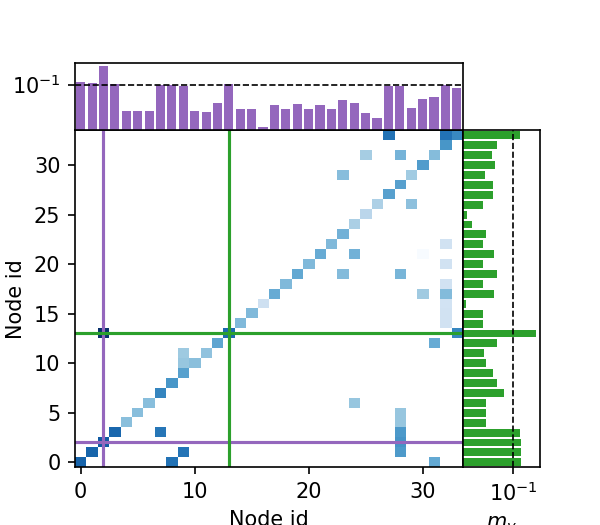

/home/arnaudon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


In [13]:
zeta = zeta_comp(mx_all, gc.dist, t, (i,j))
import matplotlib.gridspec as gridspec

plt.figure(figsize=(4,3.5))
gs = gridspec.GridSpec(2, 2, height_ratios = [ 0.2, 1], width_ratios = [1,0.2] )
gs.update(wspace=0.00)
gs.update(hspace=0)

ax1 = plt.subplot(gs[1, 0])


ax1.imshow(np.log10(zeta.T),cmap='Blues',aspect='auto', origin='auto')
ax1.axvline(i, c='C4')
ax1.axhline(i, c='C4')

ax1.axvline(j, c='C2')
ax1.axhline(j, c='C2')
ax1.set_xlabel('Node id')
ax1.set_ylabel('Node id')

ax2 = plt.subplot(gs[0, 0])
ax2.bar(np.arange(len(mx1)), mx1,color='C4',log=True)
ax2.set_xlim(-0.5,len(mx1)-0.5)
ax2.axhline(0.1,ls='--',c='k',lw=0.8)

ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

ax2.set_ylabel('$m_x$')
ax3 = plt.subplot(gs[1, 1])
ax3.barh(np.arange(len(mx2)),mx2,color='C2',log=True)
ax3.axvline(0.1,ls='--',c='k',lw=0.8)
ax3.set_ylim(-0.5,len(mx2)-0.5)
ax3.set_xlabel('$m_y$')

ax3.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)

plt.savefig('zeta.svg', bbox_inches='tight')

<IPython.core.display.Javascript object>


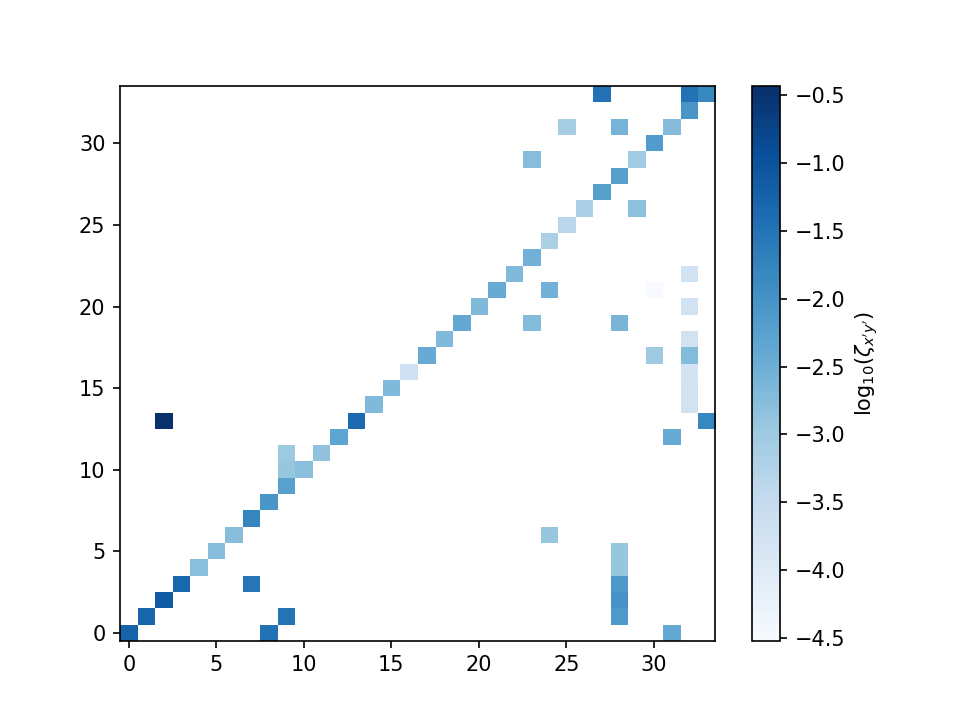

/home/arnaudon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [32]:
plt.figure()
plt.imshow(np.log10(zeta.T),cmap='Blues',aspect='auto', origin='auto')
plt.colorbar(label=r'$\mathrm{log}_{10}(\zeta_{x^\prime y^\prime})$')
plt.savefig('colorbar_zeta.svg')

<IPython.core.display.Javascript object>


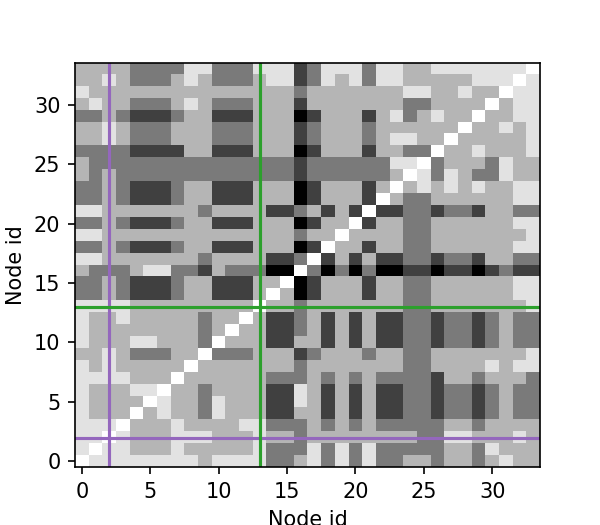

In [17]:
plt.figure(figsize=(4,3.5))
plt.imshow(gc.dist,aspect='auto', origin='auto',cmap='Greys')
ax1 = plt.gca()
ax1.axvline(i, c='C4')
ax1.axhline(i, c='C4')

ax1.axvline(j, c='C2')
ax1.axhline(j, c='C2')
ax1.set_xlabel('Node id')
ax1.set_ylabel('Node id')
plt.savefig('distance.svg', bbox_inches='tight')